In [10]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions

In [11]:
# 모델 호출
'''
Xceoption model 사용
[details]
- parameter: 22.9B
- Top-5 accuracy: 94.5%
=> 모델 크기에 비해 좋은 성능을 보여주었기에 채택
'''

model = Xception(weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


91884032/91884032 [==============================] - 0s 0us/step


In [65]:
# data 전처리
img = cv.imread("/content/poodle.jpg")

# shape 조절 (299, 299, 3)
x = np.reshape(cv.resize(img, (299, 299,)), (1, 299, 299, 3))
x = preprocess_input(x)

In [66]:
# image classification
preds = model.predict(x)
top5 = decode_predictions(preds, top = 5)[0]
print("예측결과", top5)

예측결과 [('n02113624', 'toy_poodle', 0.56306034), ('n02113712', 'miniature_poodle', 0.13234475), ('n02094433', 'Yorkshire_terrier', 0.10118624), ('n02096437', 'Dandie_Dinmont', 0.012068648), ('n02097658', 'silky_terrier', 0.007882767)]


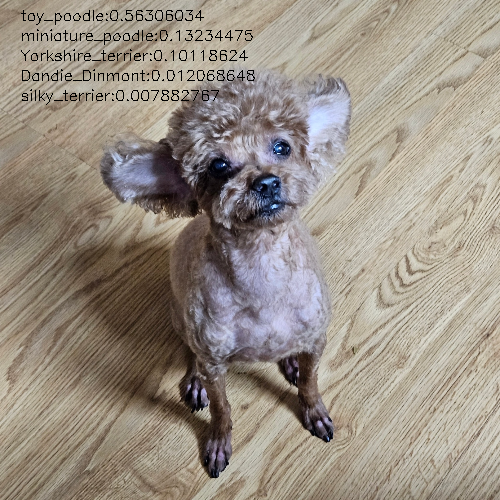

In [67]:
# 결과 출력해보기 - 그림 위에 글자 쓰기
img = cv.resize(img, (500, 500))
for i in range(5):
  cv.putText(img, top5[i][1] + ':' + str(top5[i][2]), (20, 20+i*20), cv.FONT_HERSHEY_SIMPLEX, 0.5,(0,0,0), 1)

cv2_imshow(img)

In [32]:
cv.waitKey()
cv.destroyAllWindows()

In [33]:
# GradCAM 그리기
# model 확인
# network 마다 layer name 확인
model.summary()

# 0번째 index가 속한 index
np.argmax(preds[0])

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]

265

In [59]:
from keras import backend as K

# 예측 벡터의 toy poodle 항목 -> 265번
toy_poodle_output = model.output[:, 265]

# gradient를 보고 싶은 layer =  block14_sepconv2_act(마지막 활성화 함수)
last_conv_layer_name = "block14_sepconv2_act"
last_conv_layer = model.get_layer(last_conv_layer_name)

# 선택한 feature map에 대한 toy poodle의 gradient
grads = K.gradients(toy_poodle_output, last_conv_layer.output)[0]

In [60]:
# feature map의 채널별 그래디언트 평균 값이 담긴 vector, 각 feature map 별로 평균을 구한다
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# sample image가 주어졌을 때 pooled grads와 toy poodle의 특성 맵 출력을 구한다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 샘플이미지를 주입하고 두 개의 numpy 배열을 얻는다
pooled_grads_value, conv_layer_output_value = iterate([x])

In [61]:
# toy poodle 클래스의 채널의 중요도를 특성 맵 배열의 채널에 곱한다.
# 각각의 feature map 마다 곱셈을 수행한다. -> feature map 수 산정 필요
for i in range(2048):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# x축을 기준으로 heatmap 생성, 축 주의! -> 축에 따라 다른 heatmap 그려질 수 있다.
heatmap = np.mean(conv_layer_output_value, axis = -1)

# heatmap 후처리
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

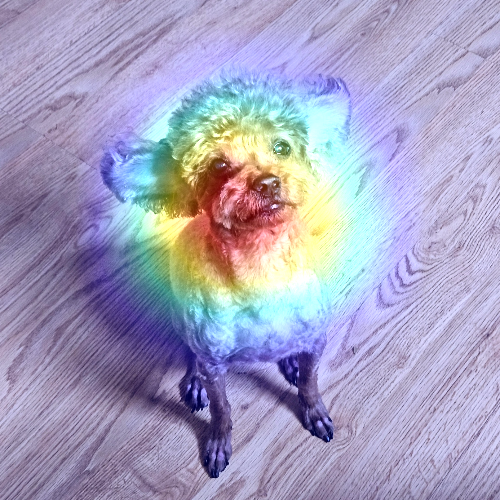

In [62]:
img = cv.imread("/content/poodle.jpg")

# heatmap을 원본 이미지 크기에 맞게 변경, 하지 않는다면 작은 크기의 heatmap만 사용
img = cv.resize(img, (500, 500))
heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 rgb format으로 변환
heatmap = np.uint8(255 * heatmap)

# 히트맵 변환
heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)

# heatmap 강도 조절
superimposed_img = heatmap * 0.4 + img

cv2_imshow(superimposed_img)